# Fitting Saturation-based Simulation Data
In this notebook, we try to fit intensity data generated using a saturation based method. The mu_a for each of the maternal and fetal layer are based on a set oxygen saturation and HB concentration. The impact of all other pigments on mu_a are ignored. The goal for this experiment is to see if we can train a model to determine these hidden variables - the Hb conc. and the saturation just by looking at the intensity values!

# Instructions
I have the parameter search in one of the cells. Run eveerything above it to be able to run that cell.
If you don't want to search, ignore that cell and run everything above and below. 

# Issues
1. Only the mu_a's are changed, not any of the other properties! 
2. Fetal performance is not nearly as good as maternal. This could be due to the noise in the far ends of the plots. Maybe interpolation would help?
3. Fetal errors: Sat: ~3% Sat., Conc: ~1.9


# Notes
1. Using interpolated values seems to make the fitting more stable. Not better however.
2. Maternal is very good.
3. Fetal just estimates a mean!

# Things to Try
1. Fetal | Maternal = known

In [63]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization
from inverse_modelling_tfo.data.intensity_interpolation import interpolate_exp
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models import RandomSplit, ValidationMethod, HoldOneOut, CVSplit
from inverse_modelling_tfo.models.custom_models import SplitChannelCNN, PerceptronReLU, PerceptronBN, PerceptronDO, PerceptronBD
from inverse_modelling_tfo.features.build_features import create_ratio, create_spatial_intensity, create_ratio_and_intensity, create_row_combos
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed
# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity.pkl')
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc.pkl')
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc2.pkl')
RAW_DATA_PATH_NEW = r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc3.pkl'

data =  pd.read_pickle(RAW_DATA_PATH_NEW)
# Drop Thickness values which I did not calculate the close concnetration points
equidistance_detector_normalization(data)

# Drop Uterus Thickness for now
data = data.drop(columns='Uterus Thickness')

# Interpolate intensity to remove noise
# data = interpolate_exp(data, weights=(1, 0.7))
data = interpolate_exp(
    data, weights=(1.0, 0.8), interpolation_function=exp_piecewise_affine, break_indices=[0, 4, 12, 20]
)
data['Intensity'] = data['Interpolated Intensity']
data = data.drop(columns='Interpolated Intensity')

# Manual log(intensity) normalization
data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log


# data = create_ratio_and_intensity(data, True)
# data, x_columns, labels = create_ratio(data, True)
data, x_columns, labels = create_spatial_intensity(data)

# data.head()
# NOTE: Have only 1 on at the same time!

# Cleanup
data.dropna(inplace=True)

# Creating Combination Features

In [34]:
# Add new columns to group close concentrations
# data['MconcCenters'] = np.round(data['Maternal Hb Concentration']).astype(int)
data['FconcCenters'] = np.round(data['Fetal Hb Concentration'] * 20, 0)
fixed_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Saturation", "FconcCenters"]
data, x_columns, labels = create_row_combos(data, x_columns, fixed_columns, ["Fetal Hb Concentration"], combo_count=3)
print(labels)

['Maternal Wall Thickness', 'Maternal Hb Concentration', 'Maternal Saturation', 'Fetal Saturation', 'FconcCenters', 'Fetal Hb Concentration 0', 'Fetal Hb Concentration 1', 'Fetal Hb Concentration 2']


In [35]:
# Column Cleanup
# data.drop(columns=['FconcCenters', 'Fetal Hb Concentration 0', 'Fetal Hb Concentration 1', 'Fetal Hb Concentration 2'] , inplace=True)
# data.head()

In [36]:
# # Create RoR
# # With combo_count = 2, we have 80 features named x_0 upto x_79. The first 40 belong to one conc and the next 40 belong to the other
# # For each pair of columns (One from the first group, the corresponding one from the second group), subtract the smaller 
# # from the bigger and divide by the smaller
# SINGLE_ROW_FEATURE_COUNT = 40
# DETECTOR_COUNT = 20

# for i in range(SINGLE_ROW_FEATURE_COUNT):
#     feature_name1 = 'x_' + str(i)
#     feature_name2 = 'x_' + str(i + SINGLE_ROW_FEATURE_COUNT)
#     new_feature_name = 'AC_' + str(i)
    
#     # Remember the features should be in log10 form -> Convert back
#     feature1 = np.power(data[feature_name1], 10)
#     feature2 = np.power(data[feature_name2], 10)

#     # The formula for AC changes depending on which one is larger
#     column_feature1_is_greater =  (feature1 - feature2) / feature2
#     column_feature2_is_greater =  (feature2 - feature1) / feature1
#     data[new_feature_name] = column_feature1_is_greater * (feature1 > feature2) + \
#         column_feature2_is_greater * (feature2 >= feature2)

# # Cleanup intensity features    
# data.drop(columns=x_columns, inplace=True)

# for i in range(DETECTOR_COUNT):
#     ac1 = 'AC_' + str(i)
#     ac2 = 'AC_' + str(i + DETECTOR_COUNT)
#     ror_feature_name = 'RoR_' + str(i)
#     data[ror_feature_name] = data[ac1] / data[ac2]

# # Cleanup - Remove the old feature columns & Set the RoR's as the new feature columns
# x_columns = ['RoR_' + str(i) for i in range(DETECTOR_COUNT)]

In [37]:
# # Data will have a bunch of infinity/NaN values. Drop them
# data.replace(np.inf, np.nan, inplace=True)
# data.dropna(inplace=True)

## Normalizing Features
x_columns will be the input features and y_columns are the target

In [65]:
## Y -> Target
# y_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"]
# y_columns = ['Maternal Wall Thickness']
# y_columns = ['Fetal Saturation']
# y_columns = ['Maternal Saturation']
# y_columns = ['Maternal Hb Concentration']
y_columns = ['Fetal Saturation']
# y_columns = ['Fetal Hb Concentration']

## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]

## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

## Model Configuration

In [66]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)

from inverse_modelling_tfo.models.train_model import ModelTrainerFactory
datagen_kw = {
    'table' : data,
    'data_loader_params' : 
        {
            'batch_size': 64, 'shuffle': True, 'num_workers': 2
        }, 
    'x_columns': x_columns,
    'y_columns': y_columns,
    'validation_method' : HoldOneOut('Maternal Wall Thickness', data['Maternal Wall Thickness'].unique()[3])
    # 'validation_method' : RandomSplit(0.8)
    # 'validation_method' : HoldOneOut('Maternal Hb Concentration', 13.0)
    # 'validation_method' : HoldOneOut('Maternal Saturation', 1.0)
}
trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 20, 10, 5, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())

## Hyper Parameter Tuning

In [40]:
# Custom Train Function 
def train_with_tuning(iteration_config):
    set_seed(42)
    trainer_tuning = trainer_factory.create()
    trainer_tuning.reporting = True     # Report at each epoch to Ray Tune
    if 'batch_size' in iteration_config:
        trainer_tuning.change_batch_size(iteration_config['batch_size'])    # If batch_size needs tuning
    trainer_tuning.set_optimizer(SGD, {'lr': iteration_config["lr"], 'momentum': iteration_config["momentum"]})
    trainer_tuning.run()

In [41]:
# Hyper Parameter Search 
# iteration_config = {
#     "lr" : tune.loguniform(1e-5, 1e-3),
#     # "batch_size": tune.choice([128, 256]),
#     "momentum": tune.uniform(0.8, 0.99),
# }
# scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=60, grace_period=5, reduction_factor=2)
# reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss"])
# result = tune.run(train_with_tuning, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
#                   num_samples=80, resources_per_trial={"cpu": 0, "gpu": 0.05},)

# # best_trial = result.get_best_trial("combined_loss", "min", "last")
# best_trial = result.get_best_trial("val_loss", "min", "last")
# print("Best trial config: {}".format(best_trial.config))
# print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
# print("Best trial final train loss: {}".format(best_trial.last_result["train_loss"]))


<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [42]:
# best_trial.config

## Custom Training

In [71]:
set_seed(42)
trainer = trainer_factory.create()
trainer.change_batch_size(256)
# trainer.set_optimizer(SGD, {'lr': best_trial.config['lr'], 'momentum': best_trial.config['lr']["momentum"]})
trainer.set_optimizer(SGD, {'lr': 3e-4, 'momentum': 0.90})
# trainer.set_optimizer(SGD, {'lr': 4e-4, 'momentum': 0.90})
trainer.epochs = 60
trainer.run()

In [44]:
# trainer.epochs = 50
# trainer.run()

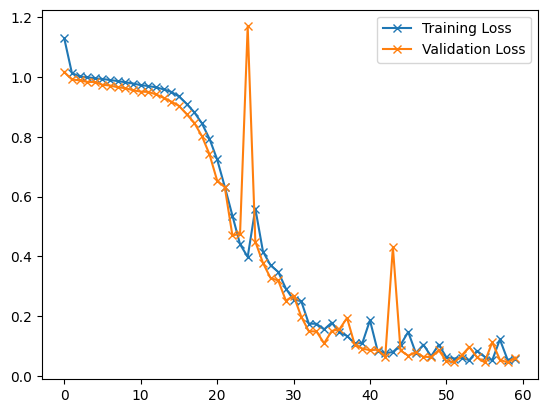

In [72]:
plt.figure()
plt.plot(trainer.train_loss, label='Training Loss', marker='x')
plt.plot(trainer.validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
# plt.xlim([0, 10])
plt.legend()

In [54]:
print(trainer)


        Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=120, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout1d(p=0.5, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=5, bias=True)
    (9): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout1d(p=0.5, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=5, out_features=1, bias=True)
    (13): Flatten(start_dim=1, end_dim=-1)
  )
)
        Optimizer Properties"
        SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    we

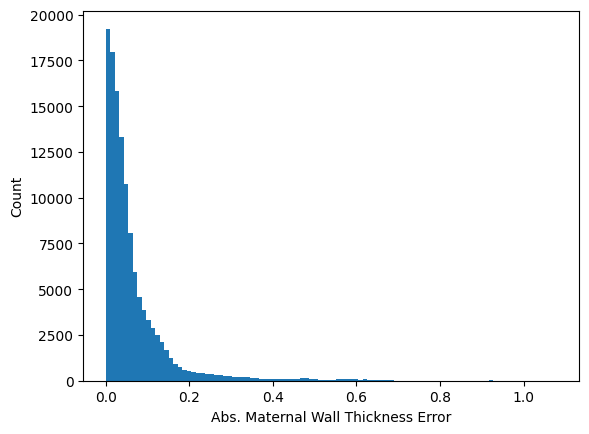

In [61]:
# Get predictions
with torch.no_grad():
    x_data = torch.tensor(data[x_columns].values, dtype=torch.float).cuda()
    trainer.model = trainer.model.eval()
    predictions = trainer.model(x_data)
    predictions = predictions.cpu().numpy()
    predictions = y_scaler.inverse_transform(predictions).flatten()
    y_data = data[y_columns].to_numpy()
    y_data = y_scaler.inverse_transform(y_data).flatten()
    absolute_error = np.abs(y_data - predictions)
    percentage_error = np.abs((y_data - predictions) / y_data) * 100
    # error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error/y_data * 100})
    error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": percentage_error})
plt.figure()
# error_df['%tage'].plot.hist(bins=100)
error_df['Absolute Error'].plot.hist(bins=100)
# plt.xlabel('(%) Error')
plt.xlabel(f'Abs. {y_columns[0]} Error')
plt.ylabel('Count')
plt.show()

In [62]:
# Top Bad Samples
VIEW_TOP_N = 50
worst_errors = error_df['Absolute Error'].argsort()[::-1][:VIEW_TOP_N]  # Worst Results
# worst_errors = error_df['Absolute Error'].argsort()[:VIEW_TOP_N]  # Best Results
combined_table = data.join(error_df)
with pd.option_context("display.max_rows", None):
    display(combined_table[labels +  ['Truth', 'Predicted', 'Absolute Error', '%tage']].iloc[worst_errors, :])

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Saturation,FconcCenters,Fetal Hb Concentration 0,Fetal Hb Concentration 1,Fetal Hb Concentration 2,Truth,Predicted,Absolute Error,%tage
64218,0.257236,11.9,1.0,0.600,2.0,0.115,0.100,0.110,8.0,6.921065,1.078935,13.486689
64220,0.257236,11.9,1.0,0.600,2.0,0.115,0.110,0.100,8.0,6.923192,1.076808,13.460106
64212,0.257236,11.9,1.0,0.600,2.0,0.110,0.100,0.115,8.0,6.929368,1.070632,13.382900
64214,0.257236,11.9,1.0,0.600,2.0,0.110,0.115,0.100,8.0,6.932654,1.067346,13.341826
64206,0.257236,11.9,1.0,0.600,2.0,0.100,0.110,0.115,8.0,6.950186,1.049814,13.122678
64224,0.257236,11.9,1.0,0.600,2.0,0.125,0.100,0.110,8.0,6.950306,1.049694,13.121170
64208,0.257236,11.9,1.0,0.600,2.0,0.100,0.115,0.110,8.0,6.951345,1.048655,13.108188
64226,0.257236,11.9,1.0,0.600,2.0,0.125,0.110,0.100,8.0,6.952434,1.047566,13.094580
64074,0.257236,11.9,1.0,0.475,2.0,0.115,0.100,0.110,8.0,6.972210,1.027790,12.847370
64216,0.257236,11.9,1.0,0.600,2.0,0.110,0.125,0.100,8.0,6.972347,1.027653,12.845665


In [49]:
# Rough MSE's in percentage
print(f'Train Error(non-normalized): {trainer.train_loss[-1] * y_scaler.var_ }')
print(f'Validation Error(non-normalized): {trainer.validation_loss[-1] * y_scaler.var_ }')

Train Error(non-normalized): [0.00451486]
Validation Error(non-normalized): [0.05714541]


In [50]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       2,420
│    └─BatchNorm1d: 2-2                  40
│    └─Dropout1d: 2-3                    --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       210
│    └─BatchNorm1d: 2-6                  20
│    └─Dropout1d: 2-7                    --
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       55
│    └─BatchNorm1d: 2-10                 10
│    └─Dropout1d: 2-11                   --
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      6
│    └─Flatten: 2-14                     --
Total params: 2,761
Trainable params: 2,761
Non-trainable params: 0

In [51]:
error_df.columns

Index(['Truth', 'Predicted', 'Absolute Error', '%tage'], dtype='object')

In [52]:
# model_name = 'msat_percep_irsi'
# import joblib
# # Save Model
# torch.save(model.state_dict(), rf'../models/{model_name}')
# # Save the Scalers for Later Use
# joblib.dump(x_scaler, rf'../models/{model_name}_xscaler')
# joblib.dump(y_scaler, rf'../models/{model_name}_yscaler')

In [53]:
# # Load Model Code
# model = PerceptronReLU([20, 10, 4, 2, 1])
# model.load_state_dict(torch.load(r'../models/fsat_delta_5det_v1'))
# model = model.cuda()
# x_scaler = joblib.load(rf'../models/{model_name}_xscaler')
# y_scaler = joblib.load(rf'../models/{model_name}_yscaler')